In [27]:
import os

print(os.getcwd())  # Prints the current working directory


d:\MS Purdue\1.5\ECE60146\HW4


In [ ]:
# this code is borrow from HW4_spring2025.pdf, my code will be follow by a comment
from PIL import Image
import os
from pycocotools.coco import COCO

# Set COCO dataset paths
data_dir = os.getcwd()
ann_file = os.path.join(data_dir, "annotations/instances_train2014.json") 
image_dir = os.path.join(data_dir, "train2014/train2014")  
output_dir = "output_datasets1"

# Load COCO dataset
coco = COCO(ann_file)

# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)

def save_image(img_info, category_name, dataset_type, split):
    """Saves the extracted image into a structured output directory for training/validation."""
    img_path = os.path.join(image_dir, img_info['file_name'])
    save_dir = os.path.join(output_dir, dataset_type, split, category_name)
    os.makedirs(save_dir, exist_ok=True)

    # Load and resize image
    img = Image.open(img_path).resize((64, 64))
    img.save(os.path.join(save_dir, img_info['file_name']))

def extract_images(cat_names, min_instances=1, max_instances=1, multiple_categories=False, dataset_type="single_instance"):
    """
    Extracts images based on object count conditions for single-instance or multi-instance datasets.
    - min_instances: Minimum number of object instances required.
    - max_instances: Maximum number of object instances allowed.
    - multiple_categories: If True, selects images with multiple different object types.
    """
    cat_ids = coco.getCatIds(catNms=cat_names)
    img_ids = coco.getImgIds(catIds=cat_ids)
    # Counter for extracted images
    extracted = 0  

    
    images_to_process = [] # List to store valid images
    target_classes = ["person", "car", "bottle", "cup", "chair"] # remeber classes we are interested in, with single categories, we need to make sure that other categories are not present
    current_category = cat_names[0] ## e.g. current_category: person
    other_categories = [cat for cat in target_classes if cat != current_category] ## e.g. other_categories: ['book', 'bottle', 'cup', 'chair']


    # loop through the images
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        # These are annotation IDs for objects detected in a specific image. (we are not using this)
        ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=False)
        # anns includes bounding box, category ID, and segmentation, area, imageID.
        anns = coco.loadAnns(ann_ids)


        # Count objects per category
        obj_counts = {}

        obj_categories = set() # set to store object categories in the image. e.g. {'person', 'chair'}
        
        # max_area_category = None # variable to store the category with the maximum area
        # max_area = 0

        for ann in anns:
            # return object category name, like obj_category: umbrella, obj_category: carrot...
            obj_category = coco.loadCats(ann['category_id'])[0]['name']

            # obj count for each category, like obj_counts: {'umbrella': 1}, obj_counts: {'carrot': 3}...
            obj_counts[obj_category] = obj_counts.get(obj_category, 0) + 1
            
            obj_categories.add(obj_category) # keep track of all object categories in the image

        #     if ann['area'] > max_area: # Track category with largest area
        #         max_area = ann['area']
        #         max_area_category = obj_category

        # if max_area_category != current_category: # Skip images with largest area not being the target category
        #     continue
        
        if dataset_type in ["single_instance", "multi_instance_same"]: # Skip images with other unwanted categories for single-instance and multi-instance same"
            if any(other_cat in obj_categories for other_cat in other_categories):
                continue

        if multiple_categories:
            # Ensure multiple object categories are present(modified)
            if len(obj_counts) >= 2 and current_category in obj_counts and any(other_cat in obj_counts for other_cat in other_categories): # modified this line to include other_categories
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1
        elif dataset_type == "multi_instance_same":
            # Ensure multiple instances of the same object category
            if cat_names[0] in obj_counts and obj_counts[cat_names[0]] >= min_instances:
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1
        else:
            # Ensure the number of instances falls within the desired range for single-instance
            if all(obj in obj_counts for obj in cat_names) and min_instances <= obj_counts[cat_names[0]] <= max_instances:
                images_to_process.append(img_info) # instead of saving the image, I append the image info to the list
                extracted += 1

        # Limit to 500 images per dataset for testing 
        if extracted >= 500:  
            break
        
    train_images = images_to_process[:400] # Split the images into training and validation sets (400 training, 100 validation)
    val_images = images_to_process[400:500] # Split the images into training and validation sets (400 training, 100 validation)

    for img_info in train_images:   # Save training and validation images
        save_image(img_info, cat_names[0], dataset_type, 'train')

    for img_info in val_images:   # Save training and validation images
        save_image(img_info, cat_names[0], dataset_type, 'val')


loading annotations into memory...
Done (t=11.11s)
creating index...
index created!


Each dataset should include at least 400 training and 100 validation images for each of any five object classes of your choice. If the selected object classes do not meet this requirement, choose alternative classes that satisfy these criteria across the datasets. If no suitable classes are found, apply data augmentation techniques from the previous homework to increase the number of images. However, do not augment more than 100-150 images per class.


In [17]:
# Extract Single-instance Dataset
extract_images(["person"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["person"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["person"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")

Datasets extracted successfully!


In [18]:
# Extract Single-instance Dataset
extract_images(["chair"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["chair"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["chair"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")

Datasets extracted successfully!


In [19]:
# Extract Single-instance Dataset
extract_images(["cup"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["cup"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["cup"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")

Datasets extracted successfully!


In [20]:
# Extract Single-instance Dataset
extract_images(["bottle"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["bottle"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["bottle"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")

Datasets extracted successfully!


In [21]:
# Extract Single-instance Dataset
extract_images(["car"], min_instances=1, max_instances=1, dataset_type="single_instance")

# Extract Multi-instance (same object) Dataset
extract_images(["car"], min_instances=2, dataset_type="multi_instance_same")

# Extract Multi-instance (different objects) Dataset
extract_images(["car"], multiple_categories=True, dataset_type="multi_instance_different")

print("Datasets extracted successfully!")

Datasets extracted successfully!


In [23]:
def count_images_in_directory(directory):
    image_extensions = {'.jpg', '.jpeg', '.png'}
    total_images = 0

    for root, _, files in os.walk(directory):
        image_count = sum(1 for file in files if os.path.splitext(file)[1].lower() in image_extensions)
        if image_count > 0:
            print(f"{root}: {image_count} images")
        total_images += image_count

    print(f"\nTotal images: {total_images}")

count_images_in_directory("output_datasets1")

output_datasets1\multi_instance_different\train\bottle: 400 images
output_datasets1\multi_instance_different\train\car: 400 images
output_datasets1\multi_instance_different\train\chair: 400 images
output_datasets1\multi_instance_different\train\cup: 400 images
output_datasets1\multi_instance_different\train\person: 400 images
output_datasets1\multi_instance_different\val\bottle: 100 images
output_datasets1\multi_instance_different\val\car: 100 images
output_datasets1\multi_instance_different\val\chair: 100 images
output_datasets1\multi_instance_different\val\cup: 100 images
output_datasets1\multi_instance_different\val\person: 100 images
output_datasets1\multi_instance_same\train\bottle: 400 images
output_datasets1\multi_instance_same\train\car: 400 images
output_datasets1\multi_instance_same\train\chair: 400 images
output_datasets1\multi_instance_same\train\cup: 400 images
output_datasets1\multi_instance_same\train\person: 400 images
output_datasets1\multi_instance_same\val\bottle: 10

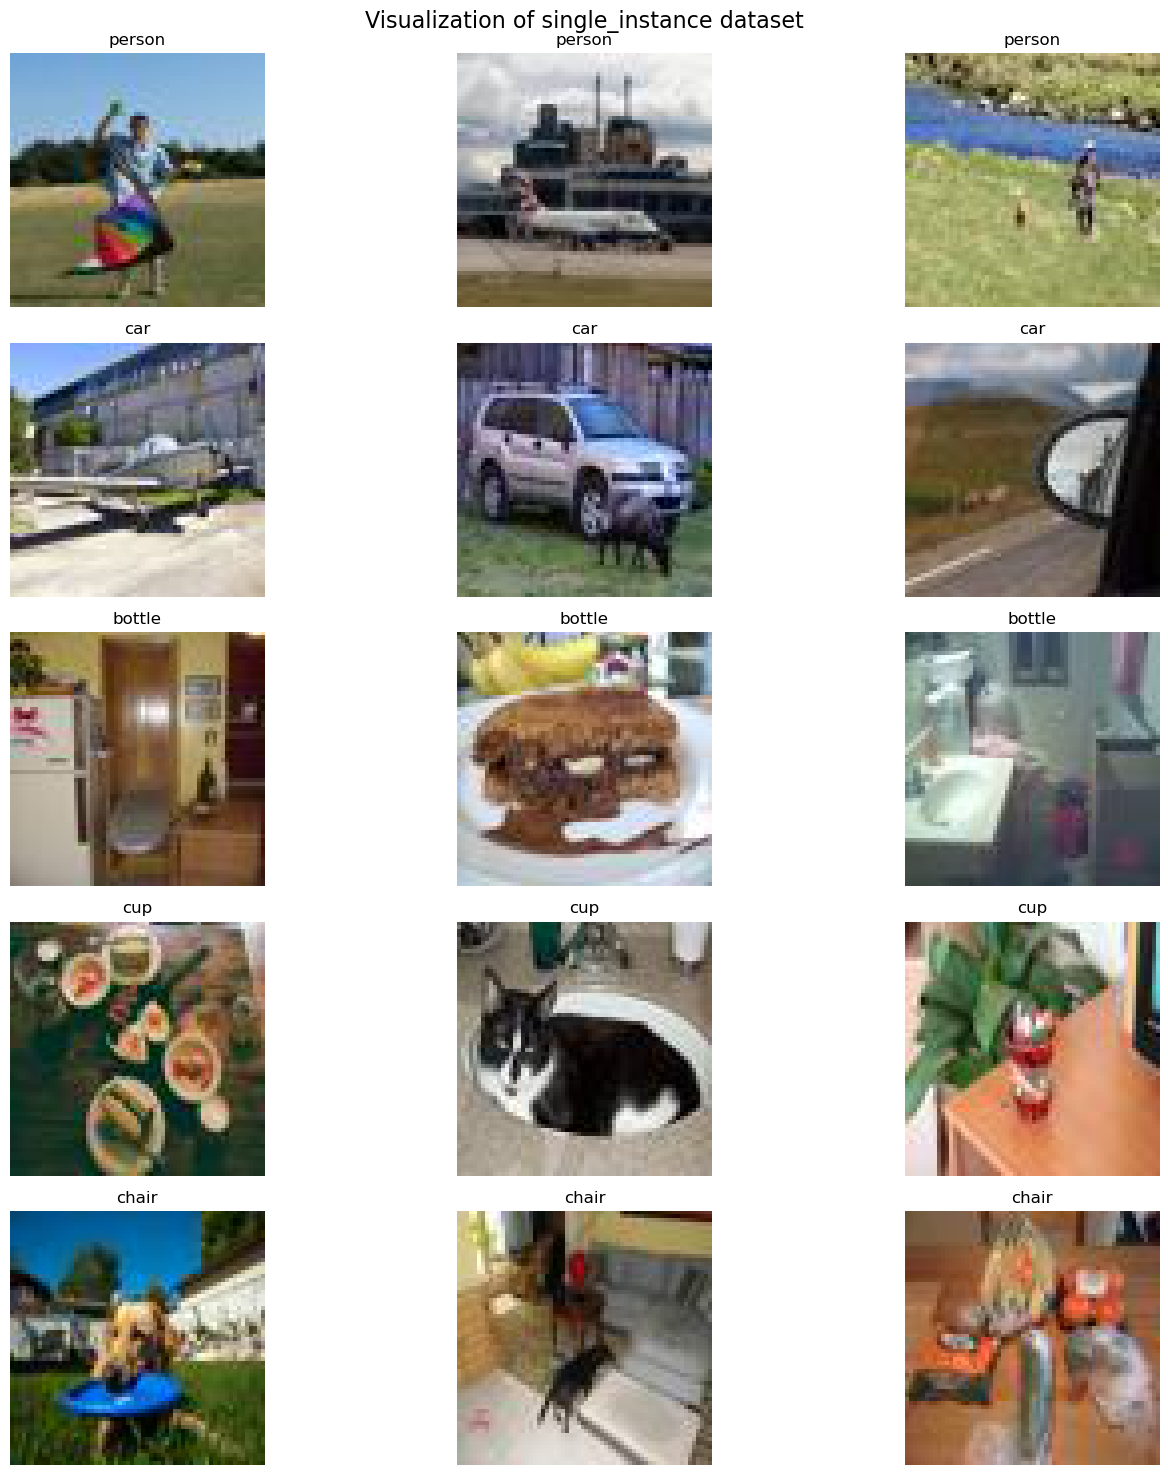

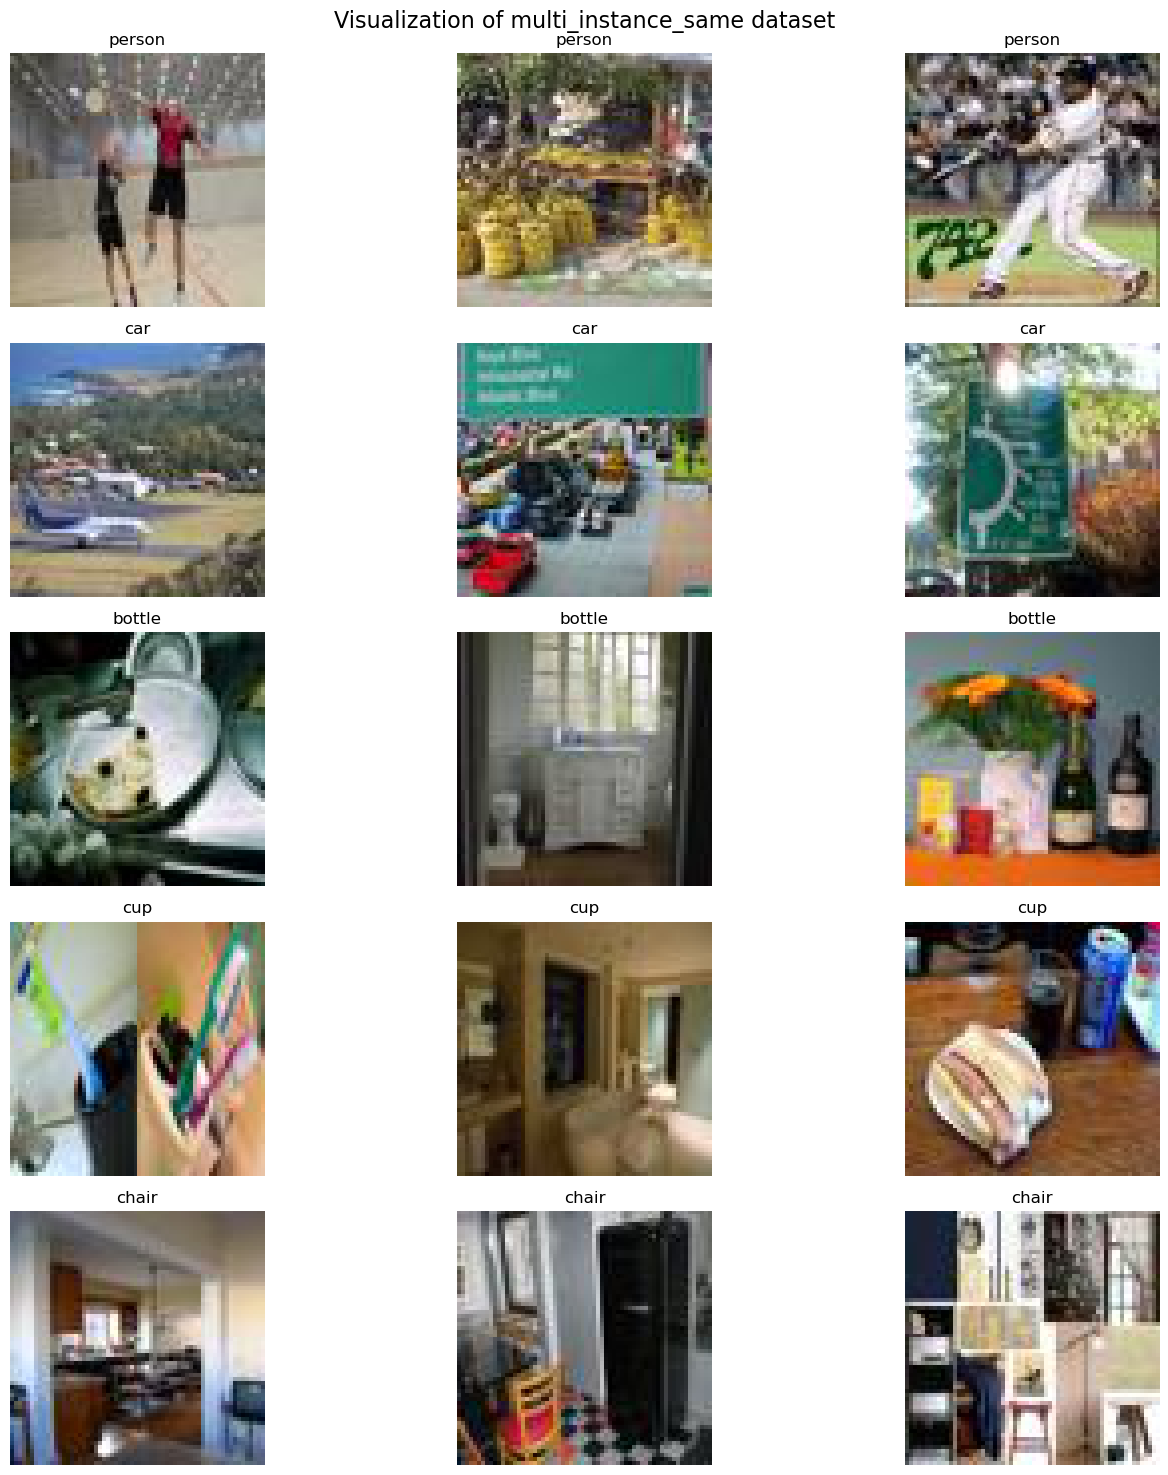

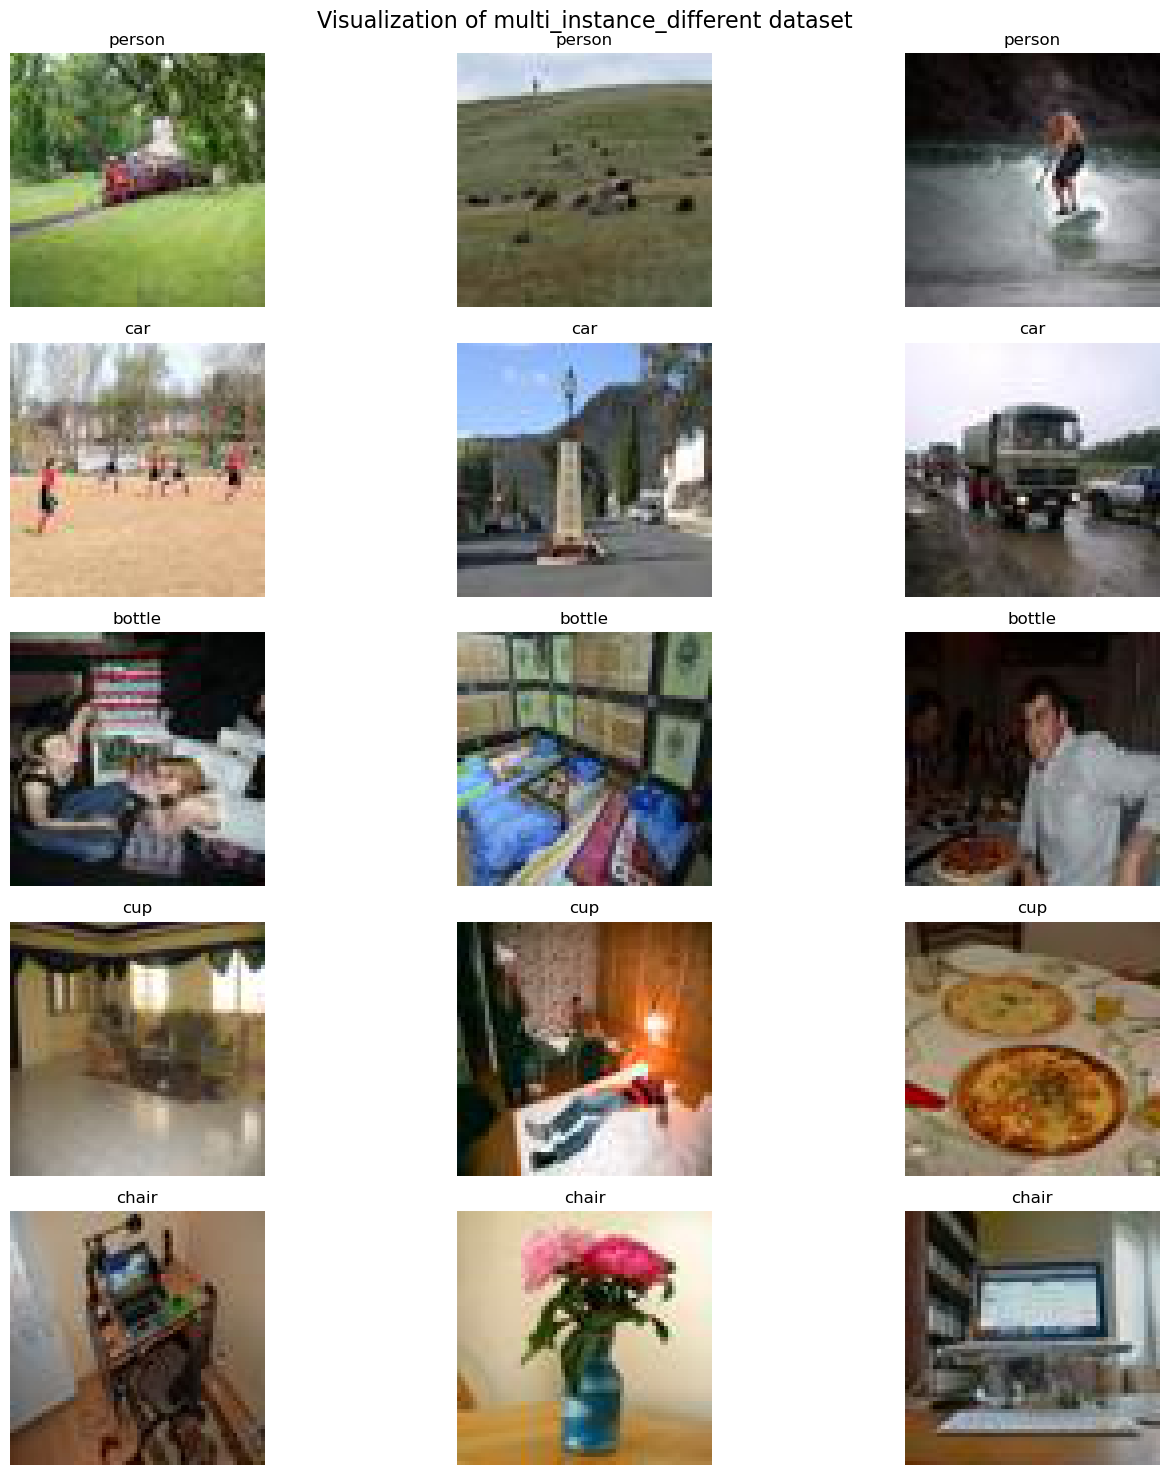

In [8]:
import matplotlib.pyplot as plt
import random

def visualize_dataset(dataset_type, classes, output_dir="output_datasets"):
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))  # 5 rows x 3 columns grid
    fig.suptitle(f"Visualization of {dataset_type} dataset", fontsize=16)
    
    image_paths = []
    
    for category in classes:
        category_path = os.path.join(output_dir, dataset_type, 'train', category)
        if os.path.exists(category_path) and os.listdir(category_path):
            category_images = [os.path.join(category_path, img) for img in os.listdir(category_path)] 
            random.shuffle(category_images)
            image_paths.extend(category_images[:3]) # Select 3 images per class
    
    image_paths = image_paths[:15]  # Ensure only 15 images for the grid
    
    for ax, img_path in zip(axes.ravel(), image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(os.path.dirname(img_path)))  # Display category name
    
    plt.tight_layout()
    plt.show()

target_classes = ["person", "car", "bottle", "cup", "chair"]
dataset_variations = ["single_instance", "multi_instance_same", "multi_instance_different"]

for variation in dataset_variations:
    visualize_dataset(variation, target_classes)